%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
! which jupyter

/home/abaumann/anaconda3/envs/cuda/bin/jupyter


In [6]:
import logging
import random
from functools import partial
from pathlib import Path

import numpy as np

import fire
import torch
from fastai.basic_data import DataBunch
from fastai.basic_train import Learner
from fastai.metrics import fbeta
from fastai.train import to_fp16
from learner import (OneHotCallBack, conll_f1, create_fp16_cb,
                     ner_loss_func)
from ner_data import NerDataset, pad
from optimizer import BertAdam
from pytorch_pretrained_bert import BertForTokenClassification
from torch.utils.data import DataLoader

In [36]:
lang='eng'

In [37]:
log_dir:str='logs'
batch_size:int=32
lr:float=5e-5
epochs:int=1
trainset:str='data/conll-2003/'
devset:str='data/conll-2003/'
testset:str='data/conll-2003/'
max_seq_len:int=128
do_lower_case:bool=False
warmup_proportion:float=0.1
grad_acc_steps:int=1
rand_seed:int=None
fp16:bool=False
loss_scale:float=None
ds_size:int=None
data_bunch_path:str='data/conll-2003/db'
freez:bool=False
one_cycle:bool=False
discr:bool=False
tuned_learner:str=None
do_train:str=False
do_eval:str=False
save:bool=False

In [38]:
bert_model = 'bert-base-cased' if lang=='eng' else 'bert-base-multilingual-cased'


In [39]:
trainset += lang + '/train.txt'
devset += lang + '/dev.txt'
testset += lang + '/test.txt'

In [40]:
if grad_acc_steps < 1:
    raise ValueError(f"""Invalid grad_acc_steps parameter:
                     {grad_acc_steps}, should be >= 1""")

# TODO proper training with grad accum step??
batch_size //= grad_acc_steps

In [41]:
train_dl = DataLoader(
    dataset=NerDataset(trainset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=pad
)

dev_dl = DataLoader(
    dataset=NerDataset(devset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad
)

test_dl = DataLoader(
    dataset=NerDataset(testset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad
)

data = DataBunch(
    train_dl= train_dl,
    valid_dl= dev_dl,
    test_dl = test_dl,
    collate_fn=pad,
    path = Path(data_bunch_path)
)


data/conll-2003/eng/train.txt
lines 14987 sents 14987
Truncated examples: 0.0% => 0/14987 

data/conll-2003/eng/dev.txt
lines 3466 sents 3466
Truncated examples: 0.0% => 0/3466 

data/conll-2003/eng/test.txt
lines 3684 sents 3684
Truncated examples: 0.0% => 0/3684 


In [42]:
batch_size

32

In [43]:

model = BertForTokenClassification.from_pretrained(bert_model, num_labels=10, cache_dir='bertm')
model = torch.nn.DataParallel(model)
optim = BertAdam

train_opt_steps = int(len(train_dl.dataset) / batch_size / grad_acc_steps) * epochs
f1 = partial(fbeta, beta=1, sigmoid=False)
loss_fun = ner_loss_func
fp16_cb_fns = partial(create_fp16_cb,
                      train_opt_steps = train_opt_steps,
                      gradient_accumulation_steps = grad_acc_steps,
                      warmup_proportion = warmup_proportion,
                      fp16 = fp16)

In [44]:
if fp16:
    try:
        from apex.optimizers import FP16_Optimizer
        from apex.optimizers import FusedAdam
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex"
                          "to use distributed and fp16 training.")
    optim, dynamic=(FusedAdam, True) if not loss_scale else (FP16_Optimizer,False)

learn = Learner(data, model, optim,
                loss_func=loss_fun,
                metrics=[conll_f1],
                true_wd=False,
                callback_fns=fp16_cb_fns,
                path='learn',
                )

if fp16: learn.to_fp16(loss_scale=loss_scale, dynamic=dynamic)


In [45]:
batch_size

32

In [46]:
lang

'eng'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


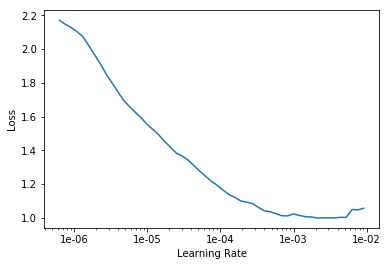

In [47]:
learn.lr_find()
learn.recorder.plot(skip_end=15)


In [ ]:
stop

In [28]:
name = "1_model"
m_path = learn.save(name, return_path=True)
m_path

PosixPath('data/conll-2003/db/models/1_model.pth')

In [ ]:
learn.fit(1, 1e-05)

epoch,train_loss,valid_loss,conll_f1,time


In [ ]:
learn.save("2_model")

In [ ]:
learn.load(name)
learn.fit(1, 3e-05)

In [ ]:
learn.load(name)
learn.fit(1, 3e-04)